尝试了频谱图+CNN等方法进行训练，但效果都一般，最后的accuracy最多达到0.6多。        
这些将整个频谱图扔进机器学习的方法可能还是过于的黑匣子，缺乏物理含义，不一定能获取实际判断障碍物种类需要的声场特征。

Using device: mps
Feature dimension: 518


/opt/anaconda3/envs/cpupytorch/lib/python3.12/site-packages/torch/functional.py:730: UserWarning: A window was not provided. A rectangular window will be applied,which is known to cause spectral leakage. Other windows such as torch.hann_window or torch.hamming_window are recommended to reduce spectral leakage.To suppress this warning and use a rectangular window, explicitly set `window=torch.ones(n_fft, device=<device>)`. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/SpectralOps.cpp:842.)
  return _VF.stft(  # type: ignore[attr-defined]
Epoch 1: 100%|██████████| 2/2 [00:02<00:00,  1.32s/it]


Epoch 1: Loss=0.6665, Accuracy=53.33%, Best=53.33%


Epoch 2: 100%|██████████| 2/2 [00:02<00:00,  1.14s/it]


Epoch 2: Loss=0.5523, Accuracy=53.33%, Best=53.33%


Epoch 3: 100%|██████████| 2/2 [00:02<00:00,  1.13s/it]


Epoch 3: Loss=0.4900, Accuracy=53.33%, Best=53.33%


Epoch 4: 100%|██████████| 2/2 [00:02<00:00,  1.14s/it]


Epoch 4: Loss=0.4293, Accuracy=53.33%, Best=53.33%


Epoch 5: 100%|██████████| 2/2 [00:02<00:00,  1.14s/it]


Epoch 5: Loss=0.3773, Accuracy=53.33%, Best=53.33%


Epoch 6: 100%|██████████| 2/2 [00:02<00:00,  1.14s/it]


Epoch 6: Loss=0.3558, Accuracy=53.33%, Best=53.33%


Epoch 7: 100%|██████████| 2/2 [00:02<00:00,  1.14s/it]


Epoch 7: Loss=0.3007, Accuracy=53.33%, Best=53.33%


Epoch 8: 100%|██████████| 2/2 [00:02<00:00,  1.14s/it]


Epoch 8: Loss=0.2824, Accuracy=53.33%, Best=53.33%


Epoch 9: 100%|██████████| 2/2 [00:02<00:00,  1.14s/it]


Epoch 9: Loss=0.2730, Accuracy=53.33%, Best=53.33%


Epoch 10: 100%|██████████| 2/2 [00:02<00:00,  1.14s/it]


Epoch 10: Loss=0.2685, Accuracy=53.33%, Best=53.33%


Epoch 11: 100%|██████████| 2/2 [00:02<00:00,  1.14s/it]


Epoch 11: Loss=0.2687, Accuracy=53.33%, Best=53.33%


Epoch 12: 100%|██████████| 2/2 [00:02<00:00,  1.15s/it]


Epoch 12: Loss=0.2660, Accuracy=53.33%, Best=53.33%


Epoch 13: 100%|██████████| 2/2 [00:02<00:00,  1.16s/it]


Epoch 13: Loss=0.2641, Accuracy=53.33%, Best=53.33%


Epoch 14: 100%|██████████| 2/2 [00:02<00:00,  1.16s/it]


Epoch 14: Loss=0.2622, Accuracy=80.00%, Best=80.00%


Epoch 15: 100%|██████████| 2/2 [00:02<00:00,  1.17s/it]


Epoch 15: Loss=0.2544, Accuracy=80.00%, Best=80.00%


Epoch 16: 100%|██████████| 2/2 [00:02<00:00,  1.17s/it]


Epoch 16: Loss=0.2517, Accuracy=93.33%, Best=93.33%


Epoch 17: 100%|██████████| 2/2 [00:02<00:00,  1.19s/it]


Epoch 17: Loss=0.2536, Accuracy=100.00%, Best=100.00%


Epoch 18: 100%|██████████| 2/2 [00:02<00:00,  1.18s/it]


Epoch 18: Loss=0.2651, Accuracy=100.00%, Best=100.00%


Epoch 19: 100%|██████████| 2/2 [00:02<00:00,  1.19s/it]


Epoch 19: Loss=0.2460, Accuracy=100.00%, Best=100.00%


Epoch 20: 100%|██████████| 2/2 [00:02<00:00,  1.19s/it]


Epoch 20: Loss=0.2537, Accuracy=100.00%, Best=100.00%


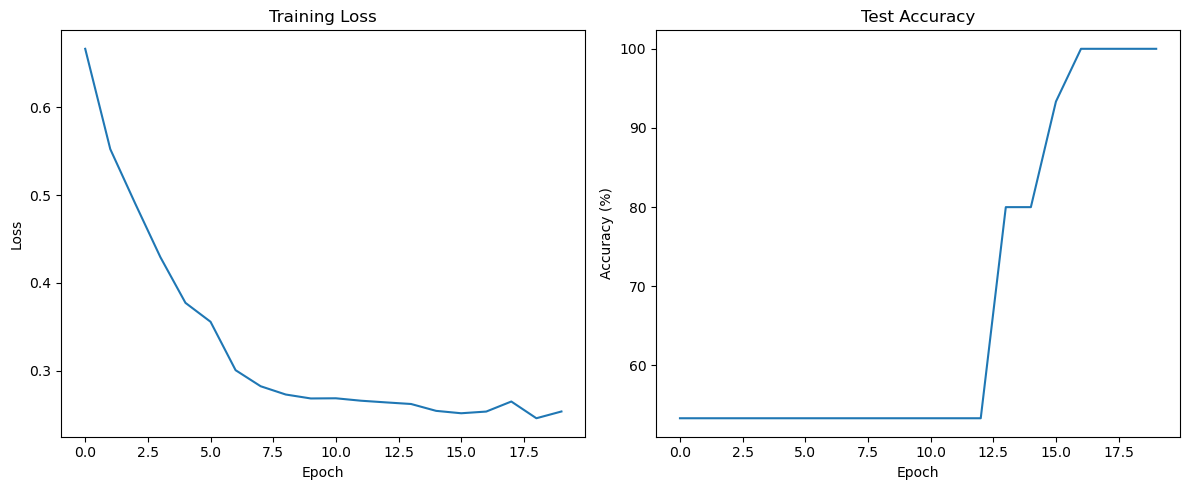


Training completed. Best accuracy: 100.00%


In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchaudio
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm import tqdm

# 设备配置
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
print(f"Using device: {device}")

# 音频参数
SAMPLE_RATE = 16000
N_FFT = 1024
HOP_LENGTH = 512


class AcousticObstacleDataset(Dataset):
    # 遍历指定目录下的音频文件，按类别分配标签
    def __init__(self, data_dir, classes=('1', '4')):
        self.filepaths = []
        self.labels = []
        
        for label_idx, class_name in enumerate(classes):
            class_dir = os.path.join(data_dir, class_name)
            for filename in os.listdir(class_dir):
                if filename.endswith('.wav'):
                    self.filepaths.append(os.path.join(class_dir, filename))
                    self.labels.append(label_idx)
    
    def __len__(self):
        return len(self.filepaths)
    
    def __getitem__(self, idx):
        waveform, _ = torchaudio.load(self.filepaths[idx])
        waveform = waveform.mean(dim=0, keepdim=True)  
        
        # 提取声场特征
        features = self.extract_acoustic_features(waveform)
        label = self.labels[idx]
        
        return features, label
    
    def extract_acoustic_features(self, waveform):
        """提取表征障碍物特性的声场特征"""
        # 1. 分离幅度谱和相位谱
        spectrogram = torch.stft(waveform, n_fft=N_FFT, hop_length=HOP_LENGTH, 
                               return_complex=True)
        magnitude = torch.abs(spectrogram)
        phase = torch.angle(spectrogram)
        
        # 2. 关键特征提取
        features = []
        
        # (1) 衍射特征 - 频谱凹陷检测
        spectral_dips = self.detect_spectral_dips(magnitude)
        features.append(spectral_dips)
        
        # (2) 反射/吸收特征 - 频带能量比
        energy_ratios = self.calc_energy_ratios(magnitude)
        features.append(energy_ratios)
        
        # (3) 运动调制特征
        modulation = self.analyze_modulation(magnitude)
        features.append(modulation)
        
        # (4) 相位畸变特征
        phase_distortion = self.analyze_phase_distortion(phase)
        features.append(phase_distortion)
        
        # 合并所有特征
        return torch.cat([f.flatten() for f in features])
    
    def detect_spectral_dips(self, magnitude):
        """检测频谱凹陷(衍射特征)"""
        # 计算频谱包络
        spectral_envelope = magnitude.mean(dim=-1)
        # 检测凹陷点
        dips = torch.diff(spectral_envelope, n=2)
        dips = F.relu(-dips)  
        return dips
    
    def calc_energy_ratios(self, magnitude):
        """计算不同频带能量比(反射/吸收特征)"""
        bands = [
            (200, 400),   # 低频
            (1000, 1200), # 中频 
            (3000, 3500)  # 高频
        ]
        
        ratios = []
        total_energy = magnitude.mean()
        for low, high in bands:
            low_bin = int(low * N_FFT / SAMPLE_RATE)
            high_bin = int(high * N_FFT / SAMPLE_RATE)
            band_energy = magnitude[..., low_bin:high_bin].mean()
            ratios.append(band_energy / (total_energy + 1e-10))
        
        return torch.tensor(ratios)
    
    def analyze_modulation(self, magnitude):
        """分析旋转麦克风的调制特征"""
        time_signal = magnitude.mean(dim=1)  
        
        padded_signal = F.pad(time_signal, (0, time_signal.size(-1)))
        conv_filter = time_signal.flip(dims=[-1]).unsqueeze(0)
        autocorr = F.conv1d(
            padded_signal.unsqueeze(0), 
            conv_filter,
            padding=0
        )[0, 0, :time_signal.size(-1)]
        
        # 提取主要周期分量
        fft = torch.fft.rfft(autocorr)
        dominant_freq = torch.argmax(torch.abs(fft))
        return torch.tensor([dominant_freq / len(fft) * (SAMPLE_RATE/HOP_LENGTH)])
    
    def analyze_phase_distortion(self, phase):
        """分析相位畸变特征"""
        # 计算相位导数(群延迟)
        phase_diff = torch.diff(phase, dim=-1)
        # 统计特性
        return torch.tensor([
            phase_diff.mean(),
            phase_diff.std(),
            torch.quantile(phase_diff, 0.9) - torch.quantile(phase_diff, 0.1)
        ])

# 特征提取器：3层全连接网络，带BatchNorm、ReLU激活和Dropout ；分类器：2层全连接网络，输出2个类别'1','4'
class AcousticObstacleClassifier(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.feature_extractor = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),
            
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),
            
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU()
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 2)
        )
    
    def forward(self, x):
        features = self.feature_extractor(x)
        return self.classifier(features)

def train_and_evaluate():
    # 加载数据集
    dataset = AcousticObstacleDataset("20250429数据/processed_data")
    
    # 检查特征维度
    sample_feature, _ = dataset[0]
    print(f"Feature dimension: {sample_feature.shape[0]}")
    
    # 划分训练测试集
    train_idx, test_idx = train_test_split(
        range(len(dataset)), test_size=0.2, random_state=42, 
        stratify=dataset.labels
    )
    
    train_set = torch.utils.data.Subset(dataset, train_idx)
    test_set = torch.utils.data.Subset(dataset, test_idx)
    
    train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_set, batch_size=32)
    
    # 初始化模型
    model = AcousticObstacleClassifier(sample_feature.shape[0]).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=5)
    
    # 训练循环
    best_acc = 0
    train_losses = []
    test_accuracies = []
    
    for epoch in range(20):
        model.train()
        epoch_loss = 0
        
        for features, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
            features, labels = features.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(features)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
        
        # 评估
        model.eval()
        correct = 0
        total = 0
        
        with torch.no_grad():
            for features, labels in test_loader:
                features, labels = features.to(device), labels.to(device)
                outputs = model(features)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        accuracy = 100 * correct / total
        scheduler.step(accuracy)
        
        train_losses.append(epoch_loss/len(train_loader))
        test_accuracies.append(accuracy)
        
        if accuracy > best_acc:
            best_acc = accuracy
            torch.save(model.state_dict(), 'best_model.pth')
        
        print(f"Epoch {epoch+1}: Loss={epoch_loss/len(train_loader):.4f}, "
              f"Accuracy={accuracy:.2f}%, Best={best_acc:.2f}%")
    
    # 可视化结果
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.title("Training Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    
    plt.subplot(1, 2, 2)
    plt.plot(test_accuracies, label='Test Accuracy')
    plt.title("Test Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.tight_layout()
    plt.show()
    
    print(f"\nTraining completed. Best accuracy: {best_acc:.2f}%")

if __name__ == "__main__":
    train_and_evaluate()

<Figure size 1000x800 with 0 Axes>

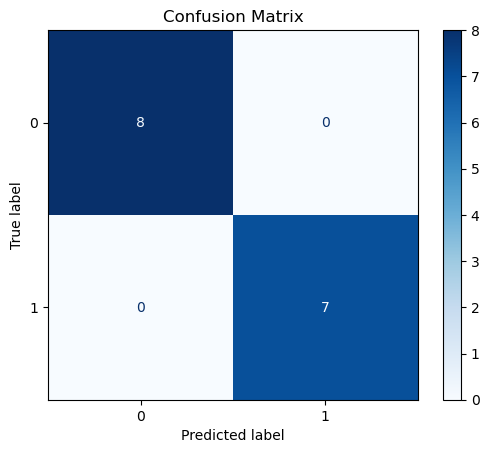

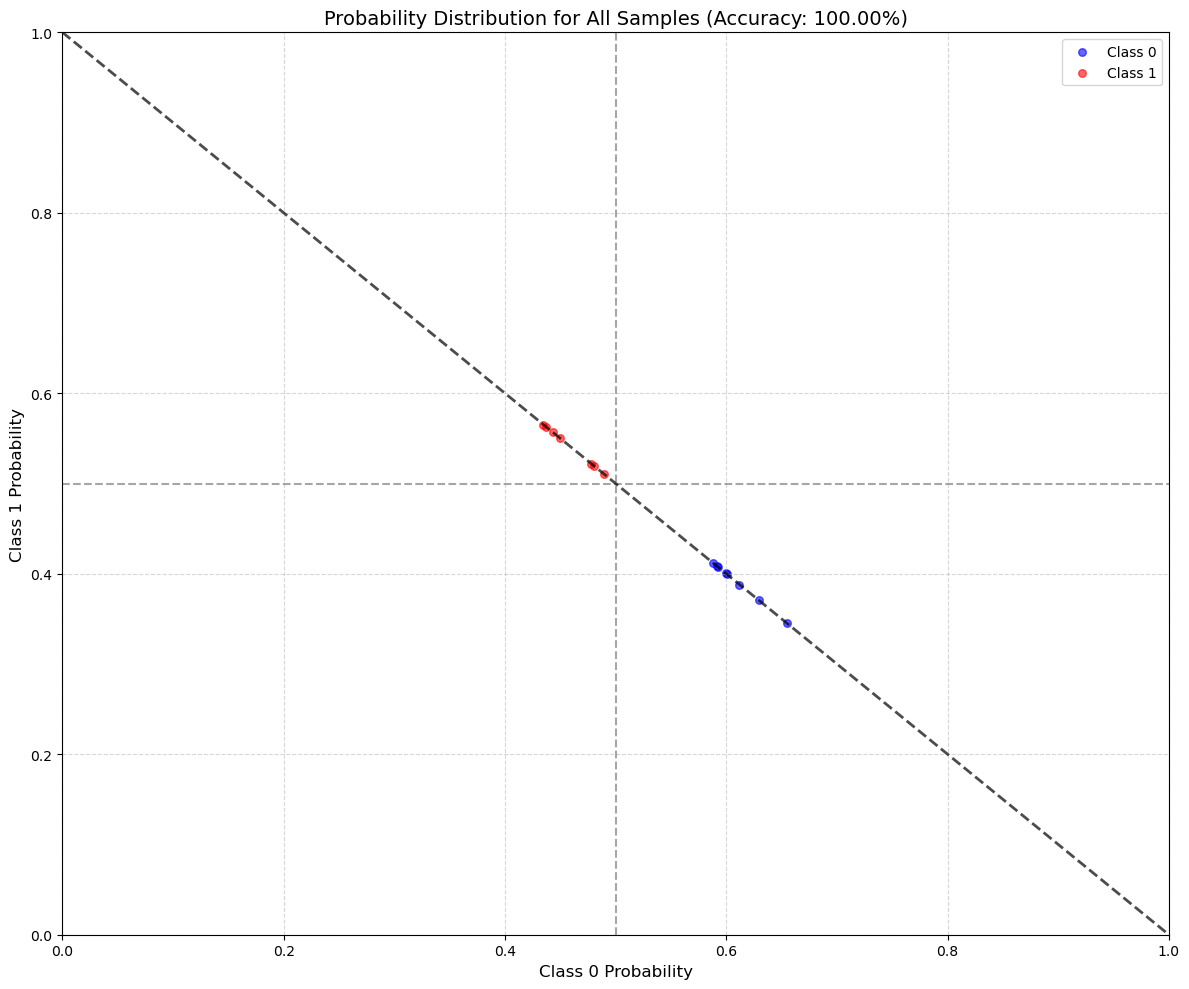

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import torch
import torch.nn.functional as F

# 加载数据集，获取特征维度
dataset = AcousticObstacleDataset("20250429数据/processed_data")
input_dim = len(dataset[0][0])  # 获取特征向量长度

# 加载最佳模型
model = AcousticObstacleClassifier(input_dim).to(device)
model.load_state_dict(torch.load('best_model.pth'))

# 评估模式
model.eval()

# 用于存储预测标签和真实标签
y_pred = []
y_true = []

# 用于存储概率分布
prob_distributions = []

with torch.no_grad():
    for features, labels in test_loader:
        features, labels = features.to(device), labels.to(device)
        outputs = model(features)
        _, predicted = torch.max(outputs.data, 1)
        
        # 存储预测标签和真实标签
        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(labels.cpu().numpy())
        
        # 存储概率分布
        probs = F.softmax(outputs, dim=1)
        prob_distributions.extend(probs.cpu().numpy())

# 计算混淆矩阵
conf_matrix = confusion_matrix(y_true, y_pred)

# 绘制混淆矩阵图
plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# 绘制概率分布图
prob_distributions = np.array(prob_distributions)
class_0_probs = prob_distributions[:, 0]
class_1_probs = prob_distributions[:, 1]

# 计算准确率
accuracy = np.mean(np.array(y_true) == np.array(y_pred)) * 100

plt.figure(figsize=(12, 10))

# 根据真实标签进行颜色编码
plt.scatter(class_0_probs[np.array(y_true) == 0], 
            class_1_probs[np.array(y_true) == 0], 
            alpha=0.6, s=30, c='blue', label='Class 0')
plt.scatter(class_0_probs[np.array(y_true) == 1], 
            class_1_probs[np.array(y_true) == 1], 
            alpha=0.6, s=30, c='red', label='Class 1')

# 0.5分界线
plt.axhline(y=0.5, color='gray', linestyle='--', alpha=0.7, lw=1.5)
plt.axvline(x=0.5, color='gray', linestyle='--', alpha=0.7, lw=1.5)

# 对角线
plt.plot([0, 1], [1, 0], 'k--', lw=2, alpha=0.7)

# 设置图形属性
plt.xlabel('Class 0 Probability', fontsize=12)
plt.ylabel('Class 1 Probability', fontsize=12)
plt.title(f'Probability Distribution for All Samples (Accuracy: {accuracy:.2f}%)', fontsize=14)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(fontsize=10)

# 显示图形
plt.tight_layout()
plt.show()